In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import contextily as ctx
import pickle

In [14]:
data = pd.read_csv(f"teste_indicium_precificacao.csv", parse_dates=["ultima_review"])

C:\Users\Leonardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\plotting\_matplotlib\core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


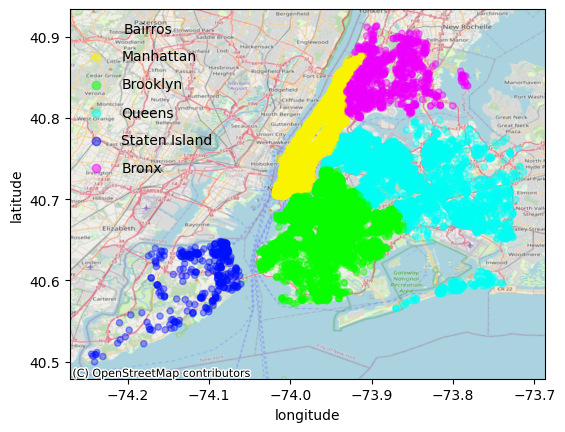

In [15]:
bairros_unicos = data['bairro_group'].unique()
cores = sns.color_palette('hsv', len(bairros_unicos))
mapeamento_cores = dict(zip(bairros_unicos, cores))

# Plote o gráfico de dispersão com cores diferentes para cada bairro
ax = data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, c=data['bairro_group'].map(mapeamento_cores), cmap='jet', colorbar=False)

# Adicionar o fundo de Nova York usando o contexto
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

# Adicionar uma legenda manualmente
for bairro, cor in mapeamento_cores.items():
    ax.scatter([], [], c=[cor], alpha=0.5, label=bairro)

ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Bairros')

plt.show()

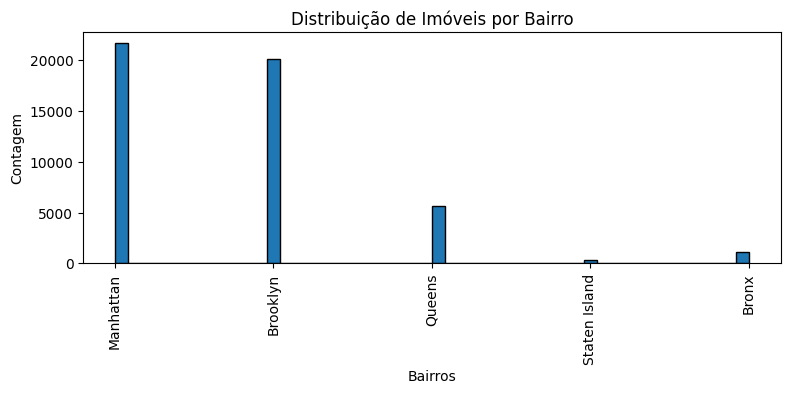

In [16]:
# Configurações para garantir que os rótulos dos bairros não se sobreponham
plt.figure(figsize=(9, 3))
plt.xticks(rotation=90)

# Criando o histograma
plt.hist(data["bairro_group"], bins=50, edgecolor='black')

# Adicionando rótulos e título
plt.xlabel('Bairros')
plt.ylabel('Contagem')
plt.title('Distribuição de Imóveis por Bairro')

# Exibir o histograma
plt.show()

In [17]:
# --- Manipulação de dados ---

# Criar as colunas com opção de ano, mês e dia a partir da coluna "ultima_review" para o modelo conseguir interpretar e preenche os dados vazios

#O modelo não apresentou resultados significantes com coluna de mês e dias, então optei por deixar apenas com a coluna do ano

data["ultima_review"] = pd.to_datetime(data["ultima_review"])
#data["ano_ultima_review"] = data["ultima_review"].dt.year.fillna(data["ultima_review"].dt.year.mean())
# data["mes_ultima_review"] = data["ultima_review"].dt.month.fillna(data["ultima_review"].dt.month.mean())
#data["dia_ultima_review"] = data["ultima_review"].dt.day.fillna(data["ultima_review"].dt.day.mean())

#Categorizando diferentes bairros e tipos de quarto
grupo_bairros = pd.get_dummies(data["bairro_group"], dtype=float)
tipo_quarto = pd.get_dummies(data["room_type"], dtype=float)

data = data.join([grupo_bairros, tipo_quarto])

#As variáveis que foram removidas não foram consideradas como de relevância para a análise preditiva no modelo ou foram substituídas por um formato que facilitou a rodagem do modelo

data = data.drop(["id", "nome", "bairro_group", "bairro", "room_type","host_name", "host_id", "ultima_review"], axis = 1)

data["reviews_por_mes"] = data["reviews_por_mes"].fillna(0)

x = data.drop('price', axis = 1)
y = data["price"]

In [18]:
#Criando uma matriz de correlação para ver o impacto de cada variável em relação a variável preço
corr_matrix = data.corr()

matrix = corr_matrix["price"].sort_values(ascending=False)

print(matrix)

print(f"\nCom essa matriz de correlação, é possível concluir que o preço do imóvel diminui consideravelmente quando o mesmo se direciona ao leste da cidade. Ou também, que imóveis em Manhattan tendem a ser mais caros, etc.\n")

price                            1.000000
Entire home/apt                  0.255859
Manhattan                        0.163977
disponibilidade_365              0.081833
calculado_host_listings_count    0.057472
minimo_noites                    0.042799
latitude                         0.033939
Staten Island                   -0.013840
Bronx                           -0.041030
numero_de_reviews               -0.047954
reviews_por_mes                 -0.050564
Shared room                     -0.053613
Queens                          -0.080205
Brooklyn                        -0.098604
longitude                       -0.150020
Private room                    -0.240249
Name: price, dtype: float64

Com essa matriz de correlação, é possível concluir que o preço do imóvel diminui consideravelmente quando o mesmo se direciona ao leste da cidade. Ou também, que imóveis em Manhattan tendem a ser mais caros, etc.



In [19]:
#Criando uma regressão linear simples

x_train_sm = sm.add_constant(x)
lr= sm.OLS(y,x_train_sm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     410.6
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:17:41   Log-Likelihood:            -3.3485e+05
No. Observations:               48894   AIC:                         6.697e+05
Df Residuals:                   48880   BIC:                         6.698e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [20]:
# Existe uma relação entre os preços e as variáveis?
print(lr.pvalues)
print(f"\nO valor p é o valor de probabilidade das variáveis respectivas determinarem sua significância no modelo. Um valor p < 0,05 é sempre desejável. Com o valor p, podemos estimar se há ou não uma relação entre as variáveis e o preço do imóvel. Nesse caso, o mínimo de noites não se mostrou relevante para essa análise, já a disponibilidade ao longo do ano, numero de reviews, longitude, entre outras variáveis com o valor p baixo, efetivas.\n")

const                             4.761178e-18
latitude                          2.205661e-11
longitude                         1.896290e-42
minimo_noites                     2.955242e-01
numero_de_reviews                 4.523963e-17
reviews_por_mes                   1.991322e-04
calculado_host_listings_count     1.621075e-07
disponibilidade_365              1.007597e-118
Bronx                             9.149180e-18
Brooklyn                          3.795054e-18
Manhattan                         2.050277e-17
Queens                            5.192884e-18
Staten Island                     6.704783e-19
Entire home/apt                   1.344603e-17
Private room                      3.546506e-18
Shared room                       2.243629e-18
dtype: float64

O valor p é o valor de probabilidade das variáveis respectivas determinarem sua significância no modelo. Um valor p < 0,05 é sempre desejável. Com o valor p, podemos estimar se há ou não uma relação entre as variáveis e o preço do i

In [21]:
#Separando dados de treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
#Função para mostrar o desempenho
def display_scores(scores):
    print("Scores:", scores)
    print("Mean Squared Error:", scores.mean())
    print("Standard deviation:", scores.std())

In [23]:
def RandomForestHyperParamOpt(): #Otimizando hiperparâmetros
    forest = RandomForestRegressor(n_estimators=30, max_features=30)
    forest.fit(x_train,y_train)
    forest_scores = cross_val_score(forest, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
    forest_rmse_scores = np.sqrt(-forest_scores)
    display_scores(forest_rmse_scores)

    #Procurando por acurácia e loss em cada hiperparâmetro para encontrar o com a melhor performance.

    param_grid = [
        {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]}, {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,2,4]},
    ]

    grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(x_train, y_train)

    print(grid_search.best_params_)

    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

RandomForestHyperParamOpt()

Scores: [182.73417723 266.50819549 232.39716243 245.83567365 301.75946262
 223.38585465 238.81441485 209.98902008 221.32470484 147.18294372]
Mean Squared Error: 226.99316095583328
Standard deviation: 40.420584674422734
{'max_features': 2, 'n_estimators': 30}
253.5734828383599 {'max_features': 2, 'n_estimators': 3}
229.8863173625304 {'max_features': 2, 'n_estimators': 10}
223.0176051417965 {'max_features': 2, 'n_estimators': 30}
253.91313205776908 {'max_features': 4, 'n_estimators': 3}
228.48712276591283 {'max_features': 4, 'n_estimators': 10}
223.36145003880597 {'max_features': 4, 'n_estimators': 30}
251.96711979402846 {'max_features': 6, 'n_estimators': 3}
232.20693733108942 {'max_features': 6, 'n_estimators': 10}
225.84047326188812 {'max_features': 6, 'n_estimators': 30}
263.0908862710854 {'max_features': 8, 'n_estimators': 3}
232.56914242969103 {'max_features': 8, 'n_estimators': 10}
226.21238115885697 {'max_features': 8, 'n_estimators': 30}
247.1727351274498 {'bootstrap': False, 'm

In [33]:
forest = RandomForestRegressor(n_estimators=30, max_features=2)
forest.fit(x_train,y_train)
forest_scores = cross_val_score(forest, x_train, y_train, scoring="neg_mean_squared_error", cv=20)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [167.35559538 177.38931179 197.50393088 308.83338539 289.13927009
 180.61162575 248.32582313 227.27116684 196.17437125 369.79768194
 125.91095181 270.67870767 233.39385882 226.4544326  194.54133504
 208.98891356 186.86905978 220.61670058 139.60522015 131.6851056 ]
Mean Squared Error: 215.05732240252283
Standard deviation: 59.355817397232634


In [25]:
#Não utilizo porque os resultados ficaram piores do que com o RandomForest, mas deixei no código apenas para mostrar que montei para critério de comparação. Montei também um modelo clusterizando com KNN, porém os resultados foram ainda piores, e para não poluir ainda mais o código, optei por tirar.

input = x.columns.shape[0]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(input,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear')
])


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose=0)

In [35]:
def ANN_predict():
    # Previsões do modelo
    previsoes = model.predict(x_test)

    # Calcula o MAE
    mae = mean_absolute_error(y_test, previsoes)

    # Calcula a média dos valores reais
    media_valores_reais = np.mean(y_test)

    # Calcula a porcentagem de desvio médio
    porcentagem_desvio_medio = (mae / media_valores_reais) * 100

    # Exibe o resultado
    print(f'A porcentagem de desvio médio dos valores reais com a Rede Neural em relação às previsões é: {porcentagem_desvio_medio:.2f}%')

ANN_predict()

306/306 [==============================] - 0s 649us/step
A porcentagem de desvio médio dos valores reais com a Rede Neural em relação às previsões é: 44.62%


In [41]:
Resultado_ANN = model.predict([[40.75362,-73.98377,1,45,0.38,2,355,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0]]) # Como a primeira linha do database era idêntica ao valor a ser previsto, eu já substituí no formato filtrado.

erro_percentual = ((1 - (Resultado_ANN[0] / 225)) * 100) * -1

print(f"O erro percentual foi de: {erro_percentual[0]}%")


print(f"A sugestão de preço é de: ", Resultado_ANN[0][0])

1/1 [==============================] - 0s 31ms/step
O erro percentual foi de: -3.7124276161193848%
A sugestão de preço é de:  216.64703


In [34]:
Resultado = forest.predict([[40.75362,-73.98377,1,45,0.38,2,355,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0]]) # Como a primeira linha do database era idêntica ao valor a ser previsto, eu já substituí no formato filtrado.

erro_percentual = ((1 - (Resultado[0] / 225)) * 100) * -1

print(f"O erro percentual foi de: {erro_percentual}%")

print(f"A sugestão de preço é de: ", Resultado[0])

O erro percentual foi de: 28.44444444444445%
A sugestão de preço é de:  289.0


C:\Users\Leonardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [42]:
print(f"\nA entrada no modelo está no formato normalizado e com uma parte dos dados filtrados. Vale ressaltar que o erro médio encontrado para a rodagem do modelo foi alto, devido a não tão relevante relação entre as variáveis dependentes e independentes.")

# Salvando o modelo inteiro em um arquivo .pkl
with open('modelo.pkl', 'wb') as f:  # Abre o arquivo para escrita em modo binário ('wb')
    pickle.dump(model, f)  # Salva o objeto "modelo" no arquivo


A entrada no modelo está no formato normalizado e com uma parte dos dados filtrados. Vale ressaltar que o erro médio encontrado para a rodagem do modelo foi alto, devido a não tão relevante relação entre as variáveis dependentes e independentes.


In [46]:
print(f"\n\nPerguntas e respostas:\n"
      f"1. Respondida ao longo da análise da relevância das variáveis\n"
      f"2.a) Em Manhattan, visto que é o local mais valorizado dentre os outros, fato o qual foi provado na matriz de correlação. \n"
      f"    b) O número mínimo de noites não, visto que o valor p é menor que 5ˆ-2. Já a disponibilidade ao longo do ano interfere sim no valor. \n"
      f"    c) Não adicionei essa variável no modelo devido a complexidade de adição no banco de dados. Porém, em uma análise realizada, foi visto que diversos nomes se repetiam, logo, é provável que se tenha sim um padrão de nomes para locais de mais alto valor, como por exemplo locais em Manhattan.\n"
      f"Das transformações que eu usei, as principais foram para separar variáveis como os bairros em categóricas, com técnicas como o OneHotEncoder. Para as outras, algumas normalizações tiveram efeitos, outras já não. Eu preenchi os dados que estavam vazios com valores médios, mas uma saída seria talvez remover esses dados com valores vazios, visto que o banco de dados está robusto. \n"
      f"O problema em questão é resolvido por Regressão, embora eu tenha tentado clusterizar para tentar identificar algum padrão como imóvel de alto padrão ou algo nesse sentido. A desvantagem é que o de classificação não daria um valor em si, daria uma classificação para o imóvel. Já a regressão, dá um valor estimado. \n"
      f"Para a medida de performance, eu otimizei os hiperparâmetros com uma função, como eu já tenho experiência prévia com modelos como os dados de preço de imóvel da California, lá foi utilizado o RandomForest devido a sua capacidade de trabalhar com uma quantidade mais robusta de dados, apesar do seu custo computacional ser mais elevado. Tentei utilizar de redes neurais também, as quais obtiveram resultados semelhantes, e como o seu modelo teve um formato robusto e creio que tem maior capacidade de melhoria e possibilidades de otimização, optei por utilizar como o meu modelo da analise. \n"
      f"Para a sugestão de preço, a minha sugestão é de $216,64"
)



Perguntas e respostas:
1. Respondida ao longo da análise da relevância das variáveis
2.a) Em Manhattan, visto que é o local mais valorizado dentre os outros, fato o qual foi provado na matriz de correlação. 
    b) O número mínimo de noites não, visto que o valor p é menor que 5ˆ-2. Já a disponibilidade ao longo do ano interfere sim no valor. 
    c) Não adicionei essa variável no modelo devido a complexidade de adição no banco de dados. Porém, em uma análise realizada, foi visto que diversos nomes se repetiam, logo, é provável que se tenha sim um padrão de nomes para locais de mais alto valor, como por exemplo locais em Manhattan.
Das transformações que eu usei, as principais foram para separar variáveis como os bairros em categóricas, com técnicas como o OneHotEncoder. Para as outras, algumas normalizações tiveram efeitos, outras já não. Eu preenchi os dados que estavam vazios com valores médios, mas uma saída seria talvez remover esses dados com valores vazios, visto que o banco d